In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

In [2]:
current_env = "local"

if current_env == "local":
    data_path = "../ump-dataset"

elif current_env == "kaggle":
    data_path = "../input/ump-dataset"
    
elif current_env == "colab":
    pass

print("data_path:", data_path)

data_path: ../ump-dataset


***
## loading data

In [3]:
features = [f"f_{i}" for i in range(300)]

features = pd.read_parquet(f"{data_path}/train.parquet", columns=features)
target = pd.read_parquet(f"{data_path}/train.parquet", columns=["target",])
time = pd.read_parquet(f"{data_path}/train.parquet", columns=["time_id",])

In [4]:
time_ids = np.sort(time.time_id.unique())
len(time_ids)

1211

In [5]:
n_time_steps = len(time_ids)
print("time steps:", n_time_steps)

valid_prop = 0.1
valid_size = int(0.1 * n_time_steps)
print("valid size:", valid_size)

time steps: 1211
valid size: 121


In [6]:
# train-valid splits
n_splits = 3
end_idx = n_time_steps 

splits = list()

for start_idx in np.arange(1211, 0, -valid_size)[1:n_splits+1]:
    valid_time_ids = time_ids[start_idx:end_idx]
    train_time_end = time_ids[start_idx]-1
    end_idx = start_idx
    
    train_idx = time.query("time_id <= @train_time_end").index
    valid_idx = time.query("time_id in @valid_time_ids").index
    splits.append((train_idx,valid_idx))

In [7]:
import gc
gc.collect()

72

***
## model training: finding number of iterations

In [8]:
def pearsonr(preds: np.array, dset: xgb.DMatrix):
    """
    Helper function to compute Pearson correlation 
    on validation dataset for LightGBM as tracking metric.
    Args:
        preds: 1d-array with the model predictions
        dset: DMatrix dataset with the labels
    Returs:
        Tuple with the corresponding output
    """
    labels = dset.get_label()
    return 'pearsonr', stats.pearsonr(preds, labels)[0]

In [9]:
model_params = {
    'tree_method': 'hist',
    'grow_policy': 'depthwise',
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.05,
    'seed': 19,
    'verbosity': 0,
    'colsample_bytree': 0.2,
    'max_depth': 8,
    'min_child_weight': 1400,
    'reg_alpha': 3.353151934210454,
    'reg_lambda': 0.039999836659986764,
    'subsample': 0.95,
    'max_bin': 512
}

[0]	valid-rmse:1.02567	valid-pearsonr:0.09479


[25]	valid-rmse:0.90788	valid-pearsonr:0.12601


[50]	valid-rmse:0.89715	valid-pearsonr:0.13286


[75]	valid-rmse:0.89592	valid-pearsonr:0.13362


[100]	valid-rmse:0.89554	valid-pearsonr:0.13422


[125]	valid-rmse:0.89531	valid-pearsonr:0.13486


[150]	valid-rmse:0.89514	valid-pearsonr:0.13542


[175]	valid-rmse:0.89500	valid-pearsonr:0.13588


[200]	valid-rmse:0.89490	valid-pearsonr:0.13631


[225]	valid-rmse:0.89478	valid-pearsonr:0.13701


[250]	valid-rmse:0.89469	valid-pearsonr:0.13755


[275]	valid-rmse:0.89464	valid-pearsonr:0.13783


[300]	valid-rmse:0.89454	valid-pearsonr:0.13856


[325]	valid-rmse:0.89452	valid-pearsonr:0.13868


[350]	valid-rmse:0.89454	valid-pearsonr:0.13853


[375]	valid-rmse:0.89458	valid-pearsonr:0.13831


[400]	valid-rmse:0.89454	valid-pearsonr:0.13867


[425]	valid-rmse:0.89451	valid-pearsonr:0.13897


[450]	valid-rmse:0.89453	valid-pearsonr:0.13897


[475]	valid-rmse:0.89449	valid-pearsonr:0.13936


[500]	valid-rmse:0.89450	valid-pearsonr:0.13941


[525]	valid-rmse:0.89447	valid-pearsonr:0.13972


[550]	valid-rmse:0.89440	valid-pearsonr:0.14040


[575]	valid-rmse:0.89438	valid-pearsonr:0.14064


[600]	valid-rmse:0.89436	valid-pearsonr:0.14090


[625]	valid-rmse:0.89436	valid-pearsonr:0.14102


[650]	valid-rmse:0.89441	valid-pearsonr:0.14078


[675]	valid-rmse:0.89439	valid-pearsonr:0.14106


[700]	valid-rmse:0.89437	valid-pearsonr:0.14141


[725]	valid-rmse:0.89431	valid-pearsonr:0.14191


[750]	valid-rmse:0.89433	valid-pearsonr:0.14186


[775]	valid-rmse:0.89434	valid-pearsonr:0.14195


[800]	valid-rmse:0.89434	valid-pearsonr:0.14205


[825]	valid-rmse:0.89442	valid-pearsonr:0.14167


[850]	valid-rmse:0.89443	valid-pearsonr:0.14174


[875]	valid-rmse:0.89439	valid-pearsonr:0.14209


[900]	valid-rmse:0.89441	valid-pearsonr:0.14208


[925]	valid-rmse:0.89440	valid-pearsonr:0.14233


[950]	valid-rmse:0.89443	valid-pearsonr:0.14230


[975]	valid-rmse:0.89440	valid-pearsonr:0.14261


[1000]	valid-rmse:0.89438	valid-pearsonr:0.14286


[1025]	valid-rmse:0.89439	valid-pearsonr:0.14291


[1050]	valid-rmse:0.89441	valid-pearsonr:0.14294


[1075]	valid-rmse:0.89438	valid-pearsonr:0.14319


[1100]	valid-rmse:0.89442	valid-pearsonr:0.14314


[1125]	valid-rmse:0.89438	valid-pearsonr:0.14350


[1150]	valid-rmse:0.89442	valid-pearsonr:0.14336


[1175]	valid-rmse:0.89443	valid-pearsonr:0.14339


[1200]	valid-rmse:0.89442	valid-pearsonr:0.14363


[1225]	valid-rmse:0.89445	valid-pearsonr:0.14360


[1250]	valid-rmse:0.89448	valid-pearsonr:0.14358


[1275]	valid-rmse:0.89449	valid-pearsonr:0.14362


[1300]	valid-rmse:0.89449	valid-pearsonr:0.14377


[1325]	valid-rmse:0.89454	valid-pearsonr:0.14362


[1350]	valid-rmse:0.89455	valid-pearsonr:0.14366


[1375]	valid-rmse:0.89454	valid-pearsonr:0.14380


[1399]	valid-rmse:0.89453	valid-pearsonr:0.14400


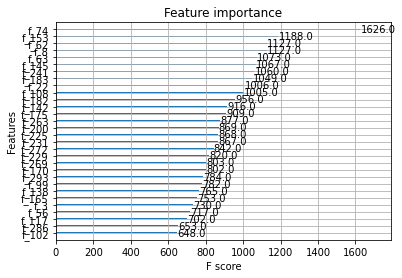

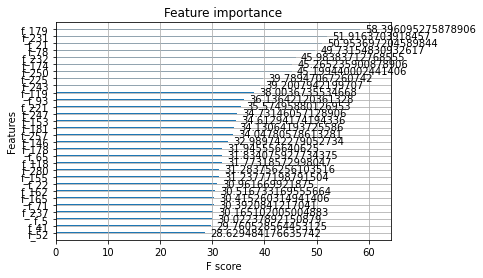

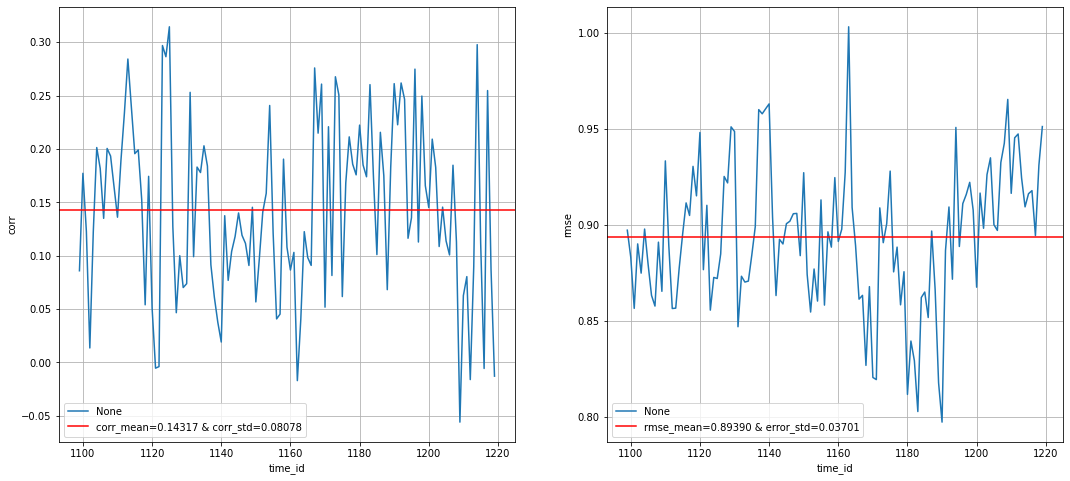

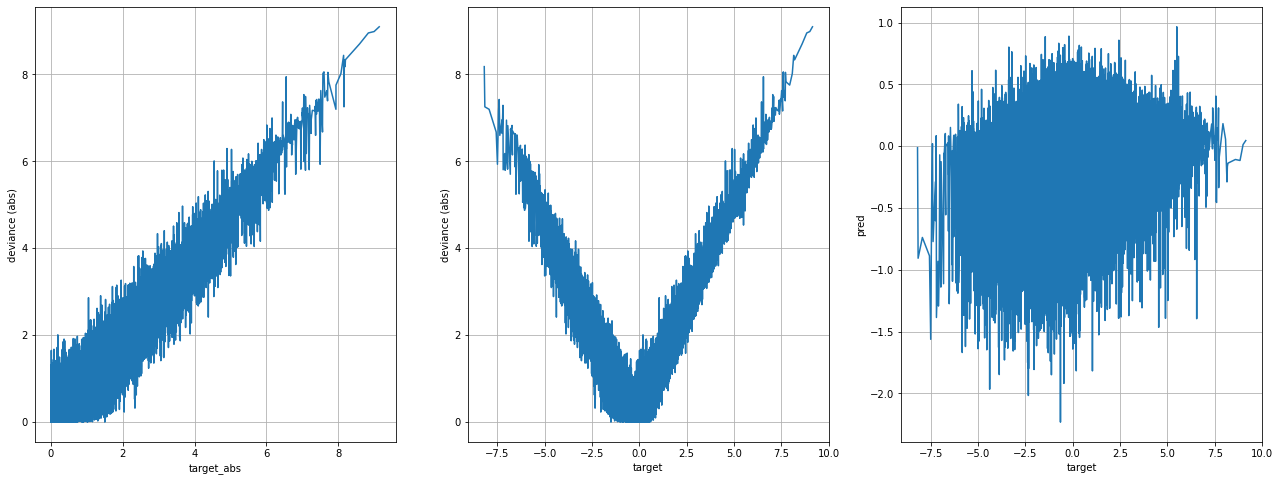

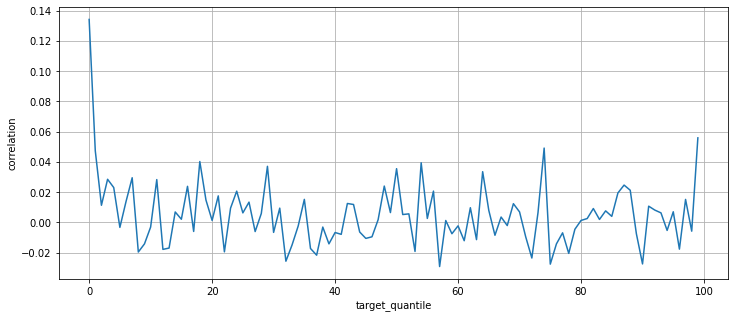

[0]	valid-rmse:1.02967	valid-pearsonr:0.07284


[25]	valid-rmse:0.91440	valid-pearsonr:0.11336


[50]	valid-rmse:0.90455	valid-pearsonr:0.12380


[75]	valid-rmse:0.90322	valid-pearsonr:0.12952


[100]	valid-rmse:0.90261	valid-pearsonr:0.13345


[125]	valid-rmse:0.90219	valid-pearsonr:0.13587


[150]	valid-rmse:0.90176	valid-pearsonr:0.13874


[175]	valid-rmse:0.90150	valid-pearsonr:0.14011


[200]	valid-rmse:0.90131	valid-pearsonr:0.14105


[225]	valid-rmse:0.90118	valid-pearsonr:0.14155


[250]	valid-rmse:0.90102	valid-pearsonr:0.14245


[275]	valid-rmse:0.90102	valid-pearsonr:0.14213


[300]	valid-rmse:0.90090	valid-pearsonr:0.14280


[325]	valid-rmse:0.90091	valid-pearsonr:0.14260


[350]	valid-rmse:0.90086	valid-pearsonr:0.14281


[375]	valid-rmse:0.90083	valid-pearsonr:0.14298


[400]	valid-rmse:0.90078	valid-pearsonr:0.14330


[425]	valid-rmse:0.90080	valid-pearsonr:0.14314


[450]	valid-rmse:0.90081	valid-pearsonr:0.14309


[475]	valid-rmse:0.90080	valid-pearsonr:0.14319


[500]	valid-rmse:0.90085	valid-pearsonr:0.14292


[525]	valid-rmse:0.90085	valid-pearsonr:0.14299


[550]	valid-rmse:0.90080	valid-pearsonr:0.14339


[575]	valid-rmse:0.90080	valid-pearsonr:0.14352


[600]	valid-rmse:0.90080	valid-pearsonr:0.14362


[625]	valid-rmse:0.90082	valid-pearsonr:0.14349


[650]	valid-rmse:0.90086	valid-pearsonr:0.14337


[675]	valid-rmse:0.90089	valid-pearsonr:0.14329


[700]	valid-rmse:0.90094	valid-pearsonr:0.14311


[725]	valid-rmse:0.90097	valid-pearsonr:0.14300


[750]	valid-rmse:0.90098	valid-pearsonr:0.14305


[775]	valid-rmse:0.90102	valid-pearsonr:0.14291


[800]	valid-rmse:0.90103	valid-pearsonr:0.14298


[825]	valid-rmse:0.90107	valid-pearsonr:0.14289


[850]	valid-rmse:0.90106	valid-pearsonr:0.14303


[875]	valid-rmse:0.90107	valid-pearsonr:0.14308


[900]	valid-rmse:0.90112	valid-pearsonr:0.14288


[925]	valid-rmse:0.90115	valid-pearsonr:0.14280


[950]	valid-rmse:0.90119	valid-pearsonr:0.14273


[975]	valid-rmse:0.90120	valid-pearsonr:0.14280


[1000]	valid-rmse:0.90122	valid-pearsonr:0.14279


[1025]	valid-rmse:0.90124	valid-pearsonr:0.14281


[1050]	valid-rmse:0.90129	valid-pearsonr:0.14261


[1075]	valid-rmse:0.90131	valid-pearsonr:0.14260


[1100]	valid-rmse:0.90134	valid-pearsonr:0.14255


[1125]	valid-rmse:0.90137	valid-pearsonr:0.14247


[1150]	valid-rmse:0.90140	valid-pearsonr:0.14242


[1175]	valid-rmse:0.90143	valid-pearsonr:0.14239


[1200]	valid-rmse:0.90149	valid-pearsonr:0.14214


[1225]	valid-rmse:0.90150	valid-pearsonr:0.14217


[1250]	valid-rmse:0.90155	valid-pearsonr:0.14204


[1275]	valid-rmse:0.90157	valid-pearsonr:0.14205


[1300]	valid-rmse:0.90161	valid-pearsonr:0.14194


[1325]	valid-rmse:0.90165	valid-pearsonr:0.14179


[1350]	valid-rmse:0.90169	valid-pearsonr:0.14167


[1375]	valid-rmse:0.90172	valid-pearsonr:0.14163


[1399]	valid-rmse:0.90178	valid-pearsonr:0.14137


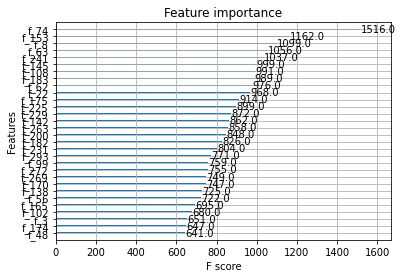

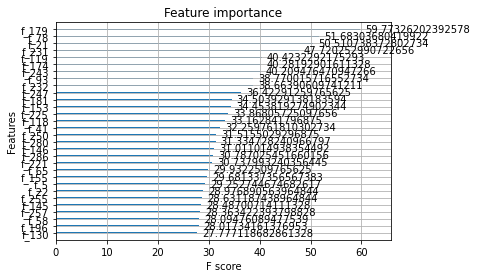

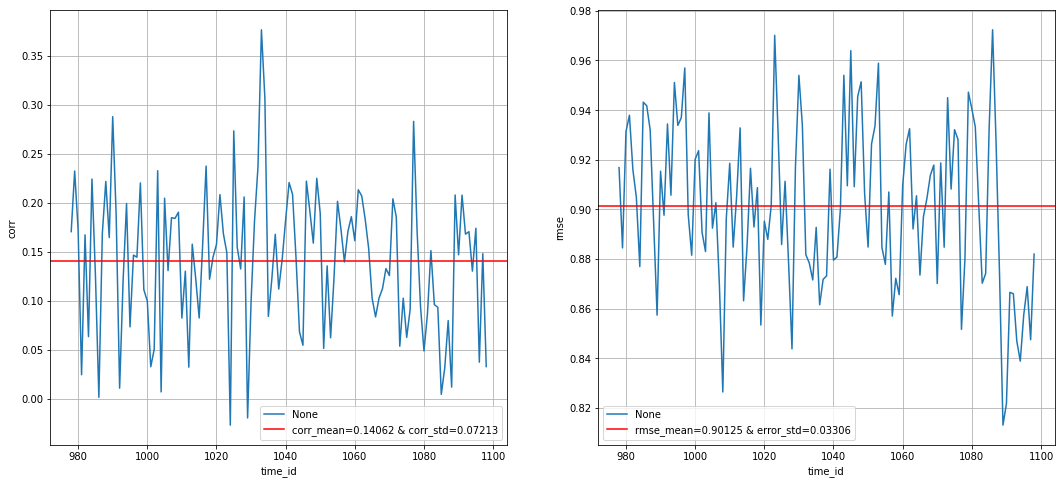

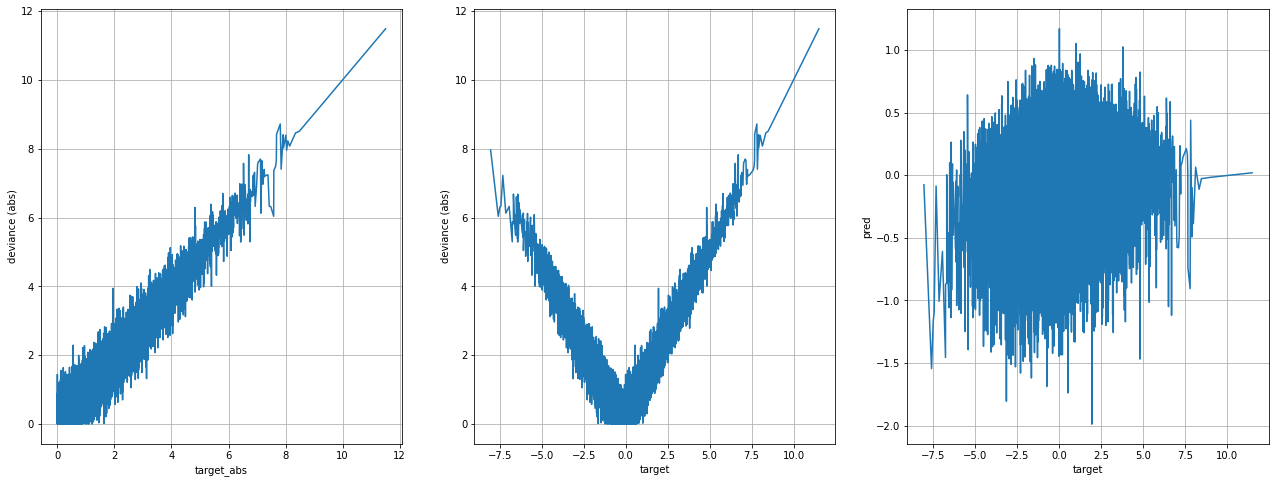

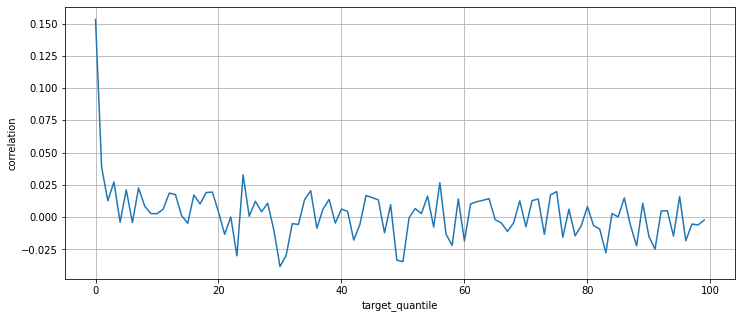

[0]	valid-rmse:1.06137	valid-pearsonr:0.06477


[25]	valid-rmse:0.94844	valid-pearsonr:0.09702


[50]	valid-rmse:0.93911	valid-pearsonr:0.10753


[75]	valid-rmse:0.93804	valid-pearsonr:0.11247


[100]	valid-rmse:0.93750	valid-pearsonr:0.11706


[125]	valid-rmse:0.93709	valid-pearsonr:0.12040


[150]	valid-rmse:0.93673	valid-pearsonr:0.12320


[175]	valid-rmse:0.93647	valid-pearsonr:0.12519


[200]	valid-rmse:0.93624	valid-pearsonr:0.12696


[225]	valid-rmse:0.93601	valid-pearsonr:0.12873


[250]	valid-rmse:0.93583	valid-pearsonr:0.13015


[275]	valid-rmse:0.93569	valid-pearsonr:0.13123


[300]	valid-rmse:0.93557	valid-pearsonr:0.13216


[325]	valid-rmse:0.93548	valid-pearsonr:0.13283


[350]	valid-rmse:0.93542	valid-pearsonr:0.13339


[375]	valid-rmse:0.93536	valid-pearsonr:0.13390


[400]	valid-rmse:0.93526	valid-pearsonr:0.13466


[425]	valid-rmse:0.93536	valid-pearsonr:0.13411


[450]	valid-rmse:0.93528	valid-pearsonr:0.13476


[475]	valid-rmse:0.93523	valid-pearsonr:0.13524


[500]	valid-rmse:0.93521	valid-pearsonr:0.13547


[525]	valid-rmse:0.93516	valid-pearsonr:0.13595


[550]	valid-rmse:0.93517	valid-pearsonr:0.13606


[575]	valid-rmse:0.93513	valid-pearsonr:0.13650


[600]	valid-rmse:0.93510	valid-pearsonr:0.13681


[625]	valid-rmse:0.93505	valid-pearsonr:0.13734


[650]	valid-rmse:0.93501	valid-pearsonr:0.13778


[675]	valid-rmse:0.93499	valid-pearsonr:0.13803


[700]	valid-rmse:0.93492	valid-pearsonr:0.13865


[725]	valid-rmse:0.93490	valid-pearsonr:0.13894


[750]	valid-rmse:0.93493	valid-pearsonr:0.13886


[775]	valid-rmse:0.93493	valid-pearsonr:0.13903


[800]	valid-rmse:0.93490	valid-pearsonr:0.13933


[825]	valid-rmse:0.93495	valid-pearsonr:0.13918


[850]	valid-rmse:0.93492	valid-pearsonr:0.13947


[875]	valid-rmse:0.93494	valid-pearsonr:0.13949


[900]	valid-rmse:0.93495	valid-pearsonr:0.13958


[925]	valid-rmse:0.93496	valid-pearsonr:0.13965


[950]	valid-rmse:0.93497	valid-pearsonr:0.13974


[975]	valid-rmse:0.93498	valid-pearsonr:0.13980


[1000]	valid-rmse:0.93499	valid-pearsonr:0.13987


[1025]	valid-rmse:0.93497	valid-pearsonr:0.14009


[1050]	valid-rmse:0.93500	valid-pearsonr:0.14006


[1075]	valid-rmse:0.93500	valid-pearsonr:0.14016


[1100]	valid-rmse:0.93504	valid-pearsonr:0.14006


[1125]	valid-rmse:0.93507	valid-pearsonr:0.14005


[1150]	valid-rmse:0.93505	valid-pearsonr:0.14028


[1175]	valid-rmse:0.93506	valid-pearsonr:0.14033


[1200]	valid-rmse:0.93507	valid-pearsonr:0.14038


[1225]	valid-rmse:0.93509	valid-pearsonr:0.14044


[1250]	valid-rmse:0.93507	valid-pearsonr:0.14066


[1275]	valid-rmse:0.93512	valid-pearsonr:0.14054


[1300]	valid-rmse:0.93513	valid-pearsonr:0.14054


[1325]	valid-rmse:0.93512	valid-pearsonr:0.14070


[1350]	valid-rmse:0.93516	valid-pearsonr:0.14064


[1375]	valid-rmse:0.93519	valid-pearsonr:0.14060


[1399]	valid-rmse:0.93520	valid-pearsonr:0.14062


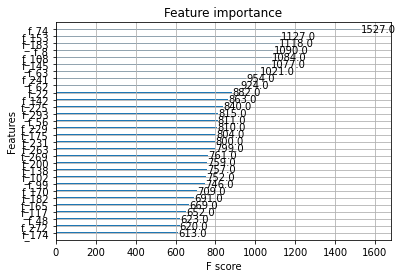

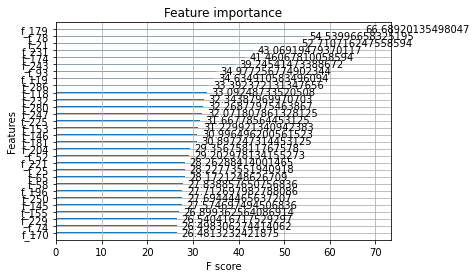

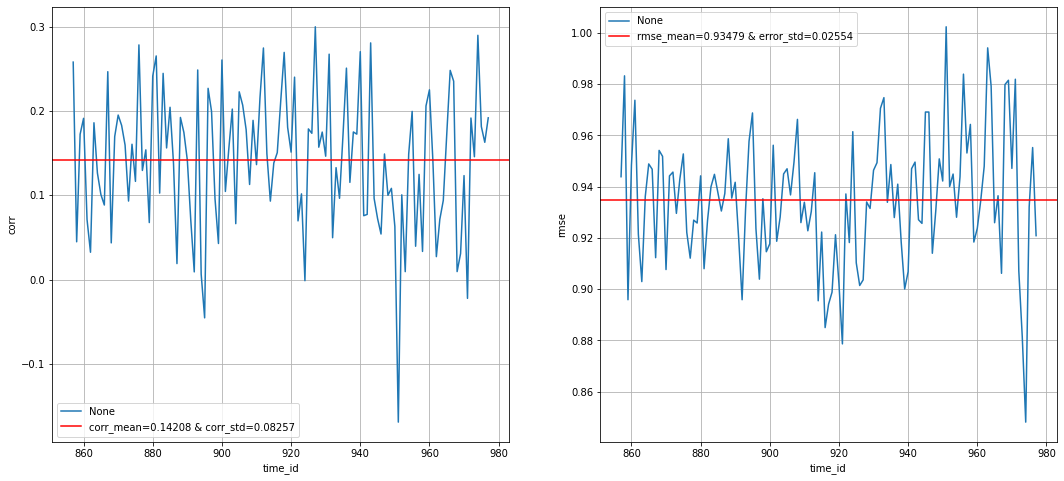

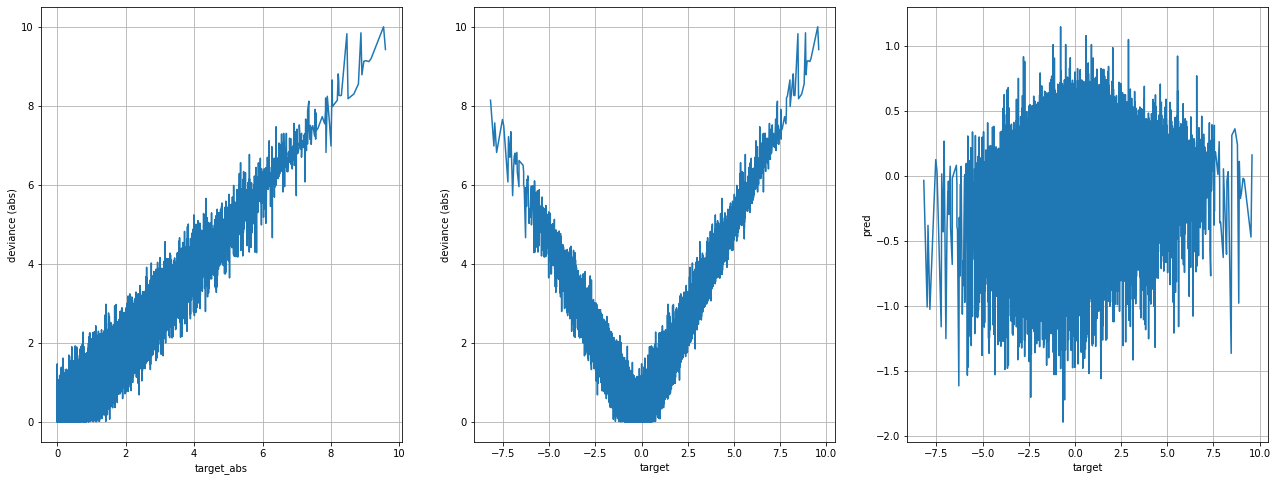

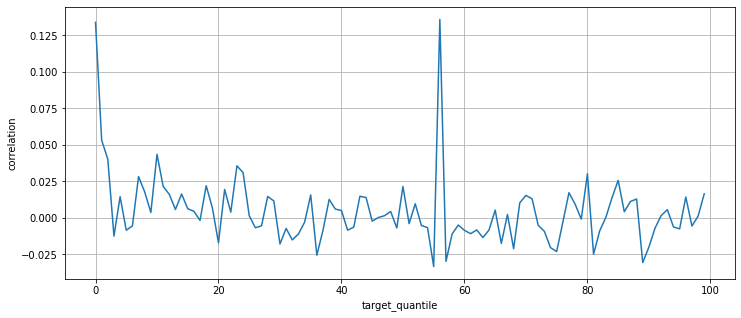

n_iterations: 1399
CPU times: user 12h 37min 36s, sys: 41min 41s, total: 13h 19min 18s
Wall time: 1h 8min 36s


In [10]:
%%time

pretrain = True
metrics = {"corr_mean":list(), "corr_std":list(), "error_mean":list(), "error_std":list(),}

if pretrain:
    
    models = list()

    for train_idx,valid_idx in splits:
        
        # input datasets for xgb
        train_dset = xgb.DMatrix(
            data=features.loc[train_idx,:],
            label=target.loc[train_idx,"target"].values,
        )
        valid_dset = xgb.DMatrix(
            data=features.loc[valid_idx,:],
            label=target.loc[valid_idx,"target"].values,
        )
        
        model = xgb.train(
            params=model_params,
            num_boost_round=1400,
            dtrain=train_dset,
            evals=[(valid_dset,"valid"),],
            feval=pearsonr,
            maximize=True,
            #early_stopping_rounds=50,
            verbose_eval=25,
        )
        models.append(model)

        xgb.plot_importance(model, importance_type="weight", max_num_features=30)
        xgb.plot_importance(model, importance_type="gain", max_num_features=30)
        plt.show()
        
        # residual analysis on oof predictions
        oof = target.loc[valid_idx,:].copy()
        oof["time_id"] = time.loc[valid_idx,"time_id"]
        oof["pred"] = model.predict(valid_dset)
        oof["target_abs"] = oof.eval("abs(target)")
        oof["dev"] = oof.eval("abs(target-pred)")

        corrs = oof.groupby("time_id").apply(lambda x: stats.pearsonr(x.target, x.pred)[0])
        corr_mean = corrs.mean()
        corr_std = corrs.std()
        error = oof.groupby("time_id").apply(lambda x: np.sqrt(np.mean((x.target-x.pred)**2)))
        error_mean = error.mean()
        error_std = error.std()
        
        metrics["corr_mean"].append(corr_mean)
        metrics["corr_std"].append(corr_std)
        metrics["error_mean"].append(error_mean)
        metrics["error_std"].append(error_std)

        plt.figure(figsize=(18,8))
        plt.subplot(1,2,1)
        corrs.plot()
        plt.axhline(
            y=corr_mean, 
            color='r', 
            linestyle='-', 
            label=f"corr_mean={corr_mean:.5f} & corr_std={corr_std:.5f}"
        )
        plt.grid()
        plt.ylabel("corr")
        plt.legend(loc="best")
        ##
        plt.subplot(1,2,2)
        error.plot()
        plt.axhline(
            y=error_mean, 
            color='r', 
            linestyle='-', 
            label=f"rmse_mean={error_mean:.5f} & error_std={error_std:.5f}"
        )
        plt.grid()
        plt.ylabel("rmse")
        plt.legend(loc="best")
        plt.show()

        plt.figure(figsize=(22,8))
        ##
        plt.subplot(1,3,1)
        plt.plot(oof.sort_values("target_abs").target_abs.values, oof.sort_values("target_abs").dev.values)
        plt.xlabel("target_abs")
        plt.ylabel("deviance (abs)")
        plt.grid()
        ##
        plt.subplot(1,3,2)
        plt.plot(oof.sort_values("target").target.values, oof.sort_values("target").dev.values)
        plt.xlabel("target")
        plt.ylabel("deviance (abs)")
        plt.grid()
        ##
        plt.subplot(1,3,3)
        plt.plot(oof.sort_values("target").target.values, oof.sort_values("target").pred.values)
        plt.xlabel("target")
        plt.ylabel("pred")
        plt.grid()
        plt.show()
        
        ## correlation vs target value
        oof["target_pct"] = ((100-1e-10)*oof.target.rank(pct=True)).astype(int)
        #oof["target_pct"] = 5*(oof.target_pct/5).astype(int)

        bucket_corr = (
            oof
            .groupby("target_pct")
            .apply(lambda x: stats.pearsonr(x.target, x.pred)[0])
            .reset_index()
            .rename({0:"corr"}, axis=1)
        )

        plt.figure(figsize=(12,5))
        plt.plot(bucket_corr["target_pct"], bucket_corr["corr"])
        plt.xlabel("target_quantile")
        plt.ylabel("correlation")
        plt.grid()
        plt.show()
           
    n_iterations = int(np.mean([m.best_iteration for m in models]))
    
else:
    # default value
    n_iterations = 600
    

print("n_iterations:", n_iterations)

In [11]:
metrics

{'corr_mean': [0.14317127643706573, 0.1406150373939707, 0.1420761087672791],
 'corr_std': [0.08077723125818057, 0.07213182651345261, 0.08257409915148149],
 'error_mean': [0.8939035804689904, 0.9012537874880587, 0.934794626271942],
 'error_std': [0.037014199436280905,
  0.03305557839128576,
  0.025538562097859985]}

In [12]:
# mean corr on validation
np.mean(metrics["corr_mean"])

0.14195414086610517

In [13]:
# mean rmse on validation
np.mean(metrics["error_mean"])

0.9099839980763305

***
## model training

[0]	train-rmse:1.04409	train-pearsonr:0.09465


[50]	train-rmse:0.90997	train-pearsonr:0.17076


[100]	train-rmse:0.90476	train-pearsonr:0.19837


[150]	train-rmse:0.90161	train-pearsonr:0.21760


[200]	train-rmse:0.89888	train-pearsonr:0.23345


[250]	train-rmse:0.89651	train-pearsonr:0.24660


[300]	train-rmse:0.89461	train-pearsonr:0.25661


[350]	train-rmse:0.89253	train-pearsonr:0.26742


[400]	train-rmse:0.89065	train-pearsonr:0.27677


[450]	train-rmse:0.88898	train-pearsonr:0.28492


[500]	train-rmse:0.88726	train-pearsonr:0.29304


[550]	train-rmse:0.88564	train-pearsonr:0.30045


[600]	train-rmse:0.88416	train-pearsonr:0.30705


[650]	train-rmse:0.88279	train-pearsonr:0.31309


[700]	train-rmse:0.88140	train-pearsonr:0.31923


[750]	train-rmse:0.88017	train-pearsonr:0.32440


[800]	train-rmse:0.87878	train-pearsonr:0.33051


[850]	train-rmse:0.87746	train-pearsonr:0.33589


[900]	train-rmse:0.87619	train-pearsonr:0.34108


[950]	train-rmse:0.87513	train-pearsonr:0.34533


[1000]	train-rmse:0.87396	train-pearsonr:0.35009


[1050]	train-rmse:0.87272	train-pearsonr:0.35494


[1100]	train-rmse:0.87158	train-pearsonr:0.35923


[1150]	train-rmse:0.87054	train-pearsonr:0.36323


[1200]	train-rmse:0.86946	train-pearsonr:0.36739


[1250]	train-rmse:0.86844	train-pearsonr:0.37119


[1300]	train-rmse:0.86737	train-pearsonr:0.37505


[1350]	train-rmse:0.86629	train-pearsonr:0.37910


[1399]	train-rmse:0.86534	train-pearsonr:0.38258


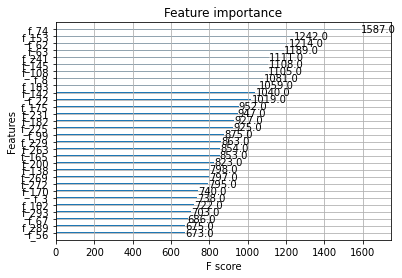

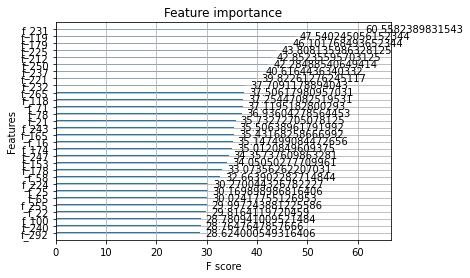

[0]	train-rmse:1.04401	train-pearsonr:0.10503


[50]	train-rmse:0.91007	train-pearsonr:0.16909


[100]	train-rmse:0.90483	train-pearsonr:0.19775


[150]	train-rmse:0.90154	train-pearsonr:0.21829


[200]	train-rmse:0.89882	train-pearsonr:0.23394


[250]	train-rmse:0.89646	train-pearsonr:0.24687


[300]	train-rmse:0.89443	train-pearsonr:0.25753


[350]	train-rmse:0.89250	train-pearsonr:0.26749


[400]	train-rmse:0.89066	train-pearsonr:0.27683


[450]	train-rmse:0.88880	train-pearsonr:0.28577


[500]	train-rmse:0.88715	train-pearsonr:0.29348


[550]	train-rmse:0.88559	train-pearsonr:0.30057


[600]	train-rmse:0.88418	train-pearsonr:0.30688


[650]	train-rmse:0.88273	train-pearsonr:0.31338


[700]	train-rmse:0.88140	train-pearsonr:0.31909


[750]	train-rmse:0.87990	train-pearsonr:0.32535


[800]	train-rmse:0.87865	train-pearsonr:0.33068


[850]	train-rmse:0.87740	train-pearsonr:0.33589


[900]	train-rmse:0.87617	train-pearsonr:0.34079


[950]	train-rmse:0.87504	train-pearsonr:0.34520


[1000]	train-rmse:0.87389	train-pearsonr:0.34984


[1050]	train-rmse:0.87272	train-pearsonr:0.35450


[1100]	train-rmse:0.87165	train-pearsonr:0.35861


[1150]	train-rmse:0.87042	train-pearsonr:0.36331


[1200]	train-rmse:0.86937	train-pearsonr:0.36720


[1250]	train-rmse:0.86839	train-pearsonr:0.37089


[1300]	train-rmse:0.86742	train-pearsonr:0.37452


[1350]	train-rmse:0.86630	train-pearsonr:0.37850


[1399]	train-rmse:0.86530	train-pearsonr:0.38222


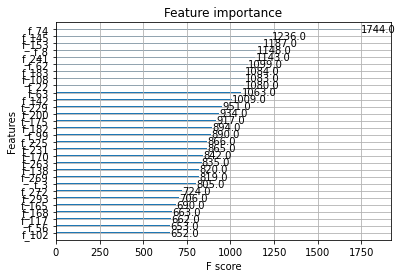

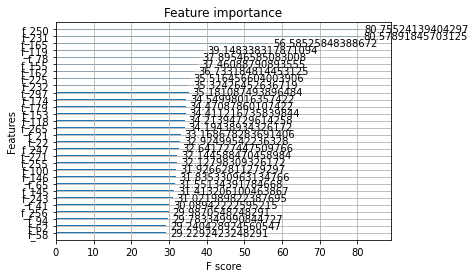

[0]	train-rmse:1.04408	train-pearsonr:0.09661


[50]	train-rmse:0.91011	train-pearsonr:0.16865


[100]	train-rmse:0.90499	train-pearsonr:0.19651


[150]	train-rmse:0.90175	train-pearsonr:0.21687


[200]	train-rmse:0.89907	train-pearsonr:0.23265


[250]	train-rmse:0.89681	train-pearsonr:0.24499


[300]	train-rmse:0.89466	train-pearsonr:0.25650


[350]	train-rmse:0.89264	train-pearsonr:0.26691


[400]	train-rmse:0.89080	train-pearsonr:0.27603


[450]	train-rmse:0.88898	train-pearsonr:0.28497


[500]	train-rmse:0.88735	train-pearsonr:0.29246


[550]	train-rmse:0.88586	train-pearsonr:0.29930


[600]	train-rmse:0.88435	train-pearsonr:0.30609


[650]	train-rmse:0.88280	train-pearsonr:0.31294


[700]	train-rmse:0.88142	train-pearsonr:0.31897


[750]	train-rmse:0.88011	train-pearsonr:0.32439


[800]	train-rmse:0.87878	train-pearsonr:0.33010


[850]	train-rmse:0.87750	train-pearsonr:0.33549


[900]	train-rmse:0.87614	train-pearsonr:0.34097


[950]	train-rmse:0.87498	train-pearsonr:0.34563


[1000]	train-rmse:0.87375	train-pearsonr:0.35047


[1050]	train-rmse:0.87275	train-pearsonr:0.35448


[1100]	train-rmse:0.87163	train-pearsonr:0.35881


[1150]	train-rmse:0.87062	train-pearsonr:0.36249


[1200]	train-rmse:0.86955	train-pearsonr:0.36666


[1250]	train-rmse:0.86842	train-pearsonr:0.37092


[1300]	train-rmse:0.86739	train-pearsonr:0.37466


[1350]	train-rmse:0.86639	train-pearsonr:0.37845


[1399]	train-rmse:0.86541	train-pearsonr:0.38195


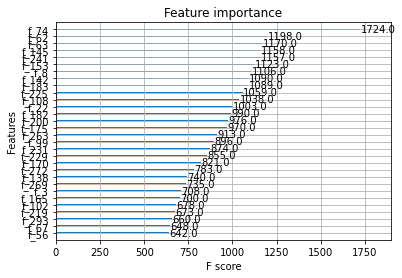

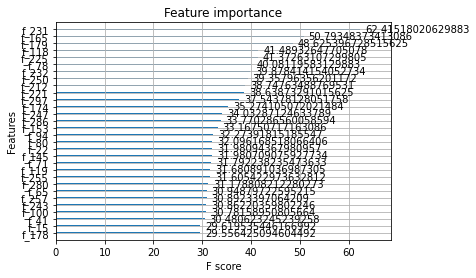

[0]	train-rmse:1.04404	train-pearsonr:0.10163


[50]	train-rmse:0.91014	train-pearsonr:0.16898


[100]	train-rmse:0.90474	train-pearsonr:0.19914


[150]	train-rmse:0.90160	train-pearsonr:0.21797


[200]	train-rmse:0.89891	train-pearsonr:0.23353


[250]	train-rmse:0.89657	train-pearsonr:0.24658


[300]	train-rmse:0.89451	train-pearsonr:0.25751


[350]	train-rmse:0.89260	train-pearsonr:0.26714


[400]	train-rmse:0.89072	train-pearsonr:0.27647


[450]	train-rmse:0.88897	train-pearsonr:0.28488


[500]	train-rmse:0.88739	train-pearsonr:0.29241


[550]	train-rmse:0.88569	train-pearsonr:0.30036


[600]	train-rmse:0.88420	train-pearsonr:0.30712


[650]	train-rmse:0.88268	train-pearsonr:0.31378


[700]	train-rmse:0.88129	train-pearsonr:0.31989


[750]	train-rmse:0.87994	train-pearsonr:0.32564


[800]	train-rmse:0.87865	train-pearsonr:0.33107


[850]	train-rmse:0.87743	train-pearsonr:0.33617


[900]	train-rmse:0.87622	train-pearsonr:0.34096


[950]	train-rmse:0.87495	train-pearsonr:0.34605


[1000]	train-rmse:0.87388	train-pearsonr:0.35046


[1050]	train-rmse:0.87269	train-pearsonr:0.35500


[1100]	train-rmse:0.87150	train-pearsonr:0.35955


[1150]	train-rmse:0.87037	train-pearsonr:0.36373


[1200]	train-rmse:0.86936	train-pearsonr:0.36747


[1250]	train-rmse:0.86823	train-pearsonr:0.37176


[1300]	train-rmse:0.86722	train-pearsonr:0.37562


[1350]	train-rmse:0.86627	train-pearsonr:0.37896


[1399]	train-rmse:0.86536	train-pearsonr:0.38228


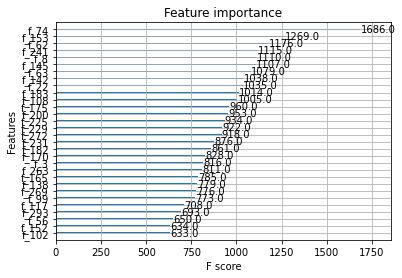

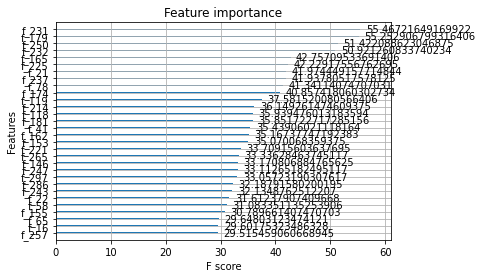

[0]	train-rmse:1.04408	train-pearsonr:0.09582


[50]	train-rmse:0.90997	train-pearsonr:0.16980


[100]	train-rmse:0.90485	train-pearsonr:0.19794


[150]	train-rmse:0.90163	train-pearsonr:0.21794


[200]	train-rmse:0.89890	train-pearsonr:0.23389


[250]	train-rmse:0.89670	train-pearsonr:0.24591


[300]	train-rmse:0.89445	train-pearsonr:0.25794


[350]	train-rmse:0.89253	train-pearsonr:0.26780


[400]	train-rmse:0.89067	train-pearsonr:0.27693


[450]	train-rmse:0.88889	train-pearsonr:0.28551


[500]	train-rmse:0.88729	train-pearsonr:0.29303


[550]	train-rmse:0.88563	train-pearsonr:0.30072


[600]	train-rmse:0.88403	train-pearsonr:0.30789


[650]	train-rmse:0.88256	train-pearsonr:0.31435


[700]	train-rmse:0.88127	train-pearsonr:0.31989


[750]	train-rmse:0.87996	train-pearsonr:0.32538


[800]	train-rmse:0.87867	train-pearsonr:0.33077


[850]	train-rmse:0.87755	train-pearsonr:0.33537


[900]	train-rmse:0.87621	train-pearsonr:0.34100


[950]	train-rmse:0.87509	train-pearsonr:0.34542


[1000]	train-rmse:0.87387	train-pearsonr:0.35031


[1050]	train-rmse:0.87283	train-pearsonr:0.35442


[1100]	train-rmse:0.87170	train-pearsonr:0.35873


[1150]	train-rmse:0.87056	train-pearsonr:0.36319


[1200]	train-rmse:0.86948	train-pearsonr:0.36736


[1250]	train-rmse:0.86840	train-pearsonr:0.37144


[1300]	train-rmse:0.86733	train-pearsonr:0.37525


[1350]	train-rmse:0.86634	train-pearsonr:0.37884


[1399]	train-rmse:0.86538	train-pearsonr:0.38242


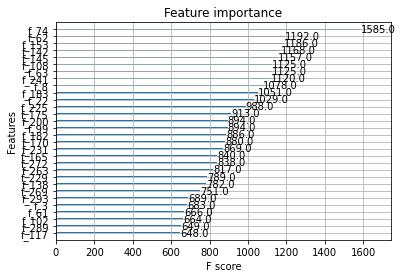

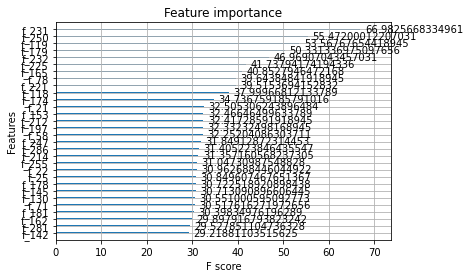

In [14]:
seeds = [2,7,11,19,23]
models = list()

train_dset = xgb.DMatrix(
    data=features,
    label=target.target.values,
)

for seed in seeds:
    _model_params = dict(model_params)
    _model_params["seed"] = seed
    
    
    model = xgb.train(
        params=_model_params,
        num_boost_round=1400,
        dtrain=train_dset,
        evals=[(train_dset,"train"),],
        feval=pearsonr,
        maximize=True,
        verbose_eval=50,
    )
    models.append(model)

    xgb.plot_importance(model, importance_type="weight", max_num_features=30)
    xgb.plot_importance(model, importance_type="gain", max_num_features=30)
    plt.show()

In [15]:
for seed,model in zip(seeds,models): 
    model.save_model(f"../ump-artifacts/xgboost-gbrt/xgb-seed{seed}.json")

***
## inference

In [16]:
if current_env == "kaggle":

    import ubiquant
    env = ubiquant.make_env()  
    iter_test = env.iter_test()
    
    features = [f"f_{i}" for i in range(300)]
    for (test_df, sample_prediction_df) in iter_test:  
        preds = [model.predict(test_df[features]) for model in models]
        sample_prediction_df['target'] = np.mean(preds, axis=0)
        env.predict(sample_prediction_df) 
        display(sample_prediction_df)

***